<a href="https://colab.research.google.com/github/shainedl/Papers-Colab/blob/master/Posterior_Collapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn, optim
from google.colab import files
from collections import defaultdict
from itertools import count, chain
import nltk
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import numpy as np
import pdb
import re
import math
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
uploaded_training = files.upload()

Saving sample_train.txt to sample_train (1).txt


In [6]:
uploaded_val = files.upload()

Saving sample_dev.txt to sample_dev.txt


In [6]:
uploaded_test = files.upload()

Saving sample_test.txt to sample_test (1).txt


In [0]:
def load_data(file):
  """
  Load training data and output vocabulary dictionaries
  """
  w2i = defaultdict(lambda x=count(0): next(x))
  w2i["<s>"] 
  w2i["</s>"] 
  w2i["<unk>"] 
  w2i['<unk>twoDigitNum']
  w2i['<unk>fourDigitNum']
  w2i['<unk>containsDigitAndAlpha']
  w2i['<unk>containsDigitAndDash']
  w2i['<unk>containsDigitAndSlash']
  w2i['<unk>containsDigitAndComma']
  w2i['<unk>containsDigitAndPeriod']
  w2i['<unk>othernum']
  w2i['<unk>allCaps']
  w2i['<unk>initCap']
  w2i['<unk>lowercase']
  w2i['<unk>time']
  data = []
  file = file.decode('utf-8')
  sentences = file.splitlines()

  for sentence in sentences:
    tokens = word_tokenize(sentence)
    for token in tokens:
      w2i[token]
    data.append(tokens)

  freq_dist = nltk.FreqDist([item for sublist in data for item in sublist])
  freq1 = set(list(freq_dist.keys())[-4000:])

  w2i = dict(w2i)
  for key in list(w2i.keys()):
    if key in freq1:
      w2i.pop(key)
  i2w = {i:w for w,i in w2i.items()}

  return data, w2i, i2w, freq_dist

In [0]:
training_data, w2i, i2w, freq_dist = load_data(uploaded_training['sample_train.txt'])

In [0]:
def load_data_test(file):
  """
  Load test and validation data
  """
  data = []
  file = file.decode('utf-8')
  sentences = file.splitlines()

  for sentence in sentences:
    tokens = word_tokenize(sentence)
    data.append(tokens)
    
  return data

In [0]:
val_data = load_data_test(uploaded_val['sample_dev.txt'])

In [0]:
test_data = load_data_test(uploaded_test['sample_test.txt'])

In [0]:
def prepare_sequence(seq, to_ix):
  idxs = [to_ix["<s>"]]
  for w in seq:
    if w in to_ix:
      idxs.append(to_ix[w])
    else:
      unk = get_word_class(w)
      idxs.append(to_ix[unk])
  idxs.append(to_ix["</s>"])
  return torch.tensor(idxs, dtype=torch.long)

In [0]:
def get_word_class(x):
    """
    Get fword class for a given word.
    Parameters
    ----------
    x : str
        word to be replaced
    Returns
    -------
    str
        corresponding word class
    """
    if re.fullmatch(r'[0-9]{2}', x):
        return '<unk>twoDigitNum'
    elif re.fullmatch(r'[0-9]{4}', x):
        return '<unk>fourDigitNum'
    elif re.fullmatch(r'A[0-9\-]+', x):
        return '<unk>containsDigitAndAlpha'
    elif re.fullmatch(r'[0-9]+\-[0-9]+', x):
        return '<unk>containsDigitAndDash'
    elif re.fullmatch(r'[0-9]+/[0-9]+/[0-9]+', x):
        return '<unk>containsDigitAndSlash'
    elif re.fullmatch(r'([0-9]+,[0-9]+)+\.[0-9]+', x):
        return '<unk>containsDigitAndComma'
    elif re.fullmatch(r'[0-9]+\.[0-9]+', x):
        return '<unk>containsDigitAndPeriod'
    elif re.fullmatch(r'[0-9]+', x):
        return '<unk>othernum'
    elif re.fullmatch(r'[A-Z]+', x):
        return '<unk>allCaps'
    elif re.fullmatch(r'[A-Z][a-z]+', x):
        return '<unk>initCap'
    elif re.fullmatch(r'[a-z]+', x):
        return '<unk>lowercase'
    elif re.match(r'[0-9]+:[0-9]+', x):
        return '<unk>time'

    return '<unk>'

In [0]:
def batch_data(batch_size, data, w2i):
  """
  Batches data with sequences of the same length
  """
  sentence_lengths = np.array([len(sentence) for sentence in data])
  sorted_idx = np.argsort(sentence_lengths)
  sorted_lengths = sentence_lengths[sorted_idx]

  len_increase_idx = []
  for i in range(1, len(sorted_lengths)):
    if sorted_lengths[i] > sorted_lengths[i-1]:
      len_increase_idx.append(i)
  len_increase_idx.append(len(sorted_lengths))

  batch_data = []
  curr_idx = 0
  for i, idx in enumerate(len_increase_idx):
    while curr_idx < idx:
      batch_sentences = []
      new_idx = min(curr_idx + batch_size, idx)
      for i in range(curr_idx, new_idx):
        sent_to_vec = prepare_sequence(data[sorted_idx[i]], w2i)
        batch_sentences.append(sent_to_vec)
      curr_idx = new_idx
      batch_sentences = torch.stack(batch_sentences).to(device=cuda)
      batch_data.append(batch_sentences)

  i = 0
  j = len(batch_data)
  while i < j:
    if i != 0 and len(batch_data[i]) <= 2 and len(batch_data[i][0]) == len(batch_data[i-1][0]):
      batch_data.append(torch.cat((batch_data[i], batch_data[i-1])))
      batch_data.pop(i)
      batch_data.pop(i-1)
      i -= 1
      j = len(batch_data)
    elif len(batch_data[i]) == 1:
      batch_data.pop(i)
      j = len(batch_data)
    else:
      i += 1

  return batch_data

In [0]:
batch_size = 4

In [0]:
use_cuda = True
cuda = torch.device('cuda')

In [0]:
batch_training = batch_data(batch_size, training_data, w2i)

In [0]:
batch_val = batch_data(batch_size, val_data, w2i)

In [0]:
batch_test = batch_data(batch_size, test_data, w2i)

In [0]:
class Encoder(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, latent_size):
    super(Encoder, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=vocab_size,
                                   embedding_dim=embedding_size)
    
    self.rnn = nn.LSTM(input_size=embedding_size,
                        hidden_size=hidden_size,
                        batch_first=True)
    
    self.fc_mu = nn.Linear(hidden_size, latent_size)
    self.fc_var = nn.Linear(hidden_size, latent_size)

    self._initialize_parameters([-0.01, 0.01], [-0.1, 0.1]) 

  def encode(self, x):
    """
    Produces a Gaussian distribution over the possible values of the code z 
    from which x could have been generated
        
    Parameters
    ----------
      x: batch size x sequence length Tensor
        observed data

    Returns
    -------
      mu: batch size x latent size Tensor
        mean of Gaussian distribution
        
      logvar: batch size x latent size Tensor
        log of variance of Gaussian distribution     
    """
    x = self.embeddings(x)
    outputs, (hidden, cell) = self.rnn(x)
    mu = self.fc_mu(hidden)
    logvar = self.fc_var(hidden)
    mu = mu.squeeze()
    logvar = logvar.squeeze()
    return mu, logvar 

  def _initialize_parameters(self, lstm_init, embed_init):
    """
    Initializes the LSTM parameters and embeddings with uniform distributions
    """
    for param in self.parameters():
      nn.init.uniform_(param, a=lstm_init[0], b=lstm_init[1])
    nn.init.uniform_(self.embeddings.weight, a=embed_init[0], b=embed_init[1])

In [0]:
class Decoder(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, latent_size):
    super(Decoder, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=vocab_size,
                                   embedding_dim=embedding_size)
    
    self.rnn = nn.LSTM(input_size=embedding_size + latent_size,
                        hidden_size=hidden_size,
                        batch_first=True)    

    self.fc_hid = nn.Linear(latent_size, hidden_size, bias=False)
    self.fc_voc = nn.Linear(hidden_size, vocab_size, bias=False)

    self.dropout = nn.Dropout()
    self._initialize_parameters([-0.01, 0.01], [-0.1, 0.1])

  def decode(self, z, inputs, nsample=1):
    """
    Given a code z it produces unscaled output corresponding to the vocabulary

    Parameters
    ----------
      z: batch size x latent size Tensor
        latent variables
      
      inputs: batch size x sequence length Tensor
        source sequence

    Returns
    -------
      output_logits: batch size x sequence length x vocab size Tensor
        unscaled output
    """
    embed = self.embeddings(inputs)
    embed = self.dropout(embed)
    if nsample > 1:
      seq_len = embed.size(1)
      batch_size, nsamples, latent_size = z.size()
      z_exp = z.expand(seq_len, batch_size, nsamples, latent_size)
      z_exp = z_exp.transpose(1,0)
      z_exp = z_exp.transpose(2,1)
      z_exp = z_exp.view(batch_size * nsamples, seq_len, latent_size)
      embed = embed.expand(nsamples, batch_size, seq_len, embedding_size)
      embed = embed.reshape(batch_size * nsamples, seq_len, embedding_size)
    else:
      z_exp = z.expand(embed.size(1), z.size(0), z.size(1))
      z_exp = z_exp.transpose(1,0)
    embed_lat = torch.cat((embed, z_exp), 2)
    if nsample > 1:
      z = z.view(batch_size * nsamples, latent_size)
    cell = self.fc_hid(z)
    cell = cell.unsqueeze(0)
    hidden = torch.tanh(cell)

    outputs, (hidden, cell) = self.rnn(embed_lat, (hidden, cell))
    outputs = self.dropout(outputs)
    output_logits = self.fc_voc(outputs)
    return output_logits

  def decode_greedy(self, z, inputs):
    """
    Given a code z it produces unscaled output corresponding to the vocabulary

    Parameters
    ----------
      z: 1 x latent size Tensor
        latent variables sampled from prior
      
      inputs: 1 x 1 Tensor
        start token

    Returns
    -------
      batch_decoded: output sequence length list
        decoded output sequence
    """
    cell = self.fc_hid(z)
    cell = cell.unsqueeze(0)
    hidden = torch.tanh(cell)

    input_d = inputs
    output_logit_prev = None
    batch_decoded = []
    z = z.unsqueeze(0)

    counter = 0
    while counter < 50:
      embed = self.embeddings(input_d)
      if counter > 0:
        z = torch.cat((z, z[0][0].unsqueeze(0).unsqueeze(0)), 1)
      embed_lat = torch.cat((embed, z), 2)
      outputs, (hidden, cell) = self.rnn(embed_lat, (hidden, cell))  
      output_logit = self.fc_voc(outputs)
      max_token = torch.argmax(output_logit, dim=2).flatten()
      if max_token[-1].item() == w2i["</s>"]:
        break
      batch_decoded.append(i2w[max_token[-1].item()])
      input_d = torch.cat((input_d, max_token[-1].unsqueeze(0).unsqueeze(0)), 1)
      counter += 1
    
    return batch_decoded

  def _initialize_parameters(self, lstm_init, embed_init):
    """
    Initializes the LSTM parameters and embeddings with uniform distributions
    """
    for param in self.parameters():
      nn.init.uniform_(param, a=lstm_init[0], b=lstm_init[1])
    nn.init.uniform_(self.embeddings.weight, a=embed_init[0], b=embed_init[1])

In [0]:
class VAE(nn.Module):

  def __init__(self, encoder, decoder):
    super(VAE, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.re_loss = nn.CrossEntropyLoss(reduction='none')
    self.pca = PCA(n_components=2)

  def forward(self, x, greedy=False):
    """
    Forward pass of the model 
    """
    mu, logvar = self.encoder.encode(x)
    kl = self.get_kl(mu, logvar)
    z = self._reparameterize(mu, logvar)

    source = x[:,:-1]
    target = x[:, 1:]
    if greedy:
      output_logits, batch_decoded = self.decoder.decode_greedy(z, source)
      re = self.get_reconstruction_error(output_logits, target)
      return kl, re, batch_decoded
    else: 
      output_logits = self.decoder.decode(z, source)
      re = self.get_reconstruction_error(output_logits, target)
      return kl, re

  def _reparameterize(self, mu, logvar, nsamples=1):
    """
    Reparameterize the random variable z to express as a deterministic variable
    
    Parameters
    ----------
      mu: batch size x latent size Tensor
        mean of Gaussian distribution
        
      logvar: batch size x latent size Tensor
        log of variance of Gaussian distribution     
    
    Returns
    -------
      z: batch size x latent size Tensor
        reparameterization of latent variables
    """
    std = torch.exp(logvar / 2)
    
    if nsamples > 1:
      batch_size, latent_size = mu.size()
      mu = mu.expand(nsamples, batch_size, latent_size)
      mu = mu.transpose(1,0)
      std = std.expand(nsamples, batch_size, latent_size)
      std = std.transpose(1,0)

    eps = torch.randn_like(std)
    return mu + std * eps  

  def get_kl(self, mu, logvar):
    """
    Returns the KLD between posterior and prior

    Parameters
    ----------
      mu: batch size x latent size Tensor
        mean of Gaussian distribution
        
      logvar: batch size x latent size Tensor
        log of variance of Gaussian distribution
    
    Returns
    -------
      kl: batch size x latent size Tensor
        kl divergence
    """
    return (mu**2 + logvar.exp() - 1 - logvar) / 2

  def get_reconstruction_error(self, output_logits, target):
    """
    Returns the reconstruction error

    Parameters
    ----------
      output_logits: batch size x sequence length x vocab size Tensor
        unscaled output
      
      target: batch size x sequence length Tensor
        target sequence
    """
    output_logits = output_logits.view(-1, output_logits.size(2))
    target = target.contiguous().view(-1)
    return self.re_loss(output_logits, target)

  def pca_2d(self, x):
    """
    https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
    """
    mu, logvar = self.encoder.encode(x)
    z = self._reparameterize(mu, logvar)
    source = x[:,:-1]
    _, batch_decoded = decoder.decode_greedy(z, source)
    np_z = z.cpu().detach().numpy()
    pd_z = pd.DataFrame(x)
    sc_z = StandardScaler().fit_transform(pd_z)
    principal_components = self.pca.fit_transform(sc_z)
    principal_df = pd.DataFrame(data = principal_components \
                    , columns = ['principal component 1', 'principal component 2'])
    return principal_df, batch_decoded

  def importance_sampling(self, x, K, nsamples):
    """
    Helpful Link: http://paulrubenstein.co.uk/deriving-the-variational-lower-bound/

    Returns the negative log likehood approximation using importance sampling

    Parameters
    ----------
      x: batch size x sequence length Tensor
        observed data

      K: int
        number of total samples

      nsamples: int
        number of samples at each iteration

    """
    mu, logvar = self.encoder.encode(x)
    mu_un = mu.unsqueeze(1)
    logvar_un = logvar.unsqueeze(1) 
    
    loss = []
    for k in range(int(K / nsamples)):
      z = self._reparameterize(mu, logvar, nsamples)
      logq_zx = -0.5 * (mu_un.size(2) * math.log(2 * math.pi) + logvar_un.sum(dim=-1)) \
                - 0.5 * ((z - mu_un)**2 / (logvar_un.exp())).sum(dim=-1)
      logp_z = (-0.5 * math.log(2 * math.pi) - z**2 / 2).sum(dim=-1)
      kl = logq_zx - logp_z

      source = x[:,:-1]
      target = x[:, 1:]
      batch_size, seq_len = target.size()
      target = target.expand(nsamples, batch_size, seq_len)
      target = target.transpose(1,0)
      output_logits = self.decoder.decode(z, source, nsamples)
      re = self.get_reconstruction_error(output_logits, target)      
      re = re.view(batch_size, nsamples, -1).sum(dim=-1)

      loss.append(-re - kl)

    ll = torch.stack(loss,1).view(batch_size,-1).logsumexp(-1) - math.log(K)
    nll = -ll
    return nll

In [0]:
vocab_size = len(w2i)
embedding_size = 128
hidden_size = 512 
latent_size = 32

In [0]:
print_every = round(len(batch_training) / batch_size)

In [0]:
class DecayLearning:
  """
  Class updated from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
  """
  def __init__(self, patience=2):
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.update_lr = False

  def __call__(self, val_loss):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
    elif score < self.best_score:
      self.counter += 1
      if self.counter >= self.patience:
        self.update_lr = True
    else:
      self.best_score = score
      self.counter = 0

In [0]:
def interpolate(latent_size, sample1, sample2):
  
  for w in range(11):
    weight = w * 0.1
    sample = weight * sample2 + (1-weight) * sample1
    batch_decoded = decoder.decode_greedy(sample, torch.zeros(1, dtype=torch.long, device=cuda).unsqueeze(0))
    print(*batch_decoded)

Pre-training on Autoencoder objective

Pre-training ran for 3 hours

In [0]:
def train(epoch):
  """
  Trains the model
  """
  model.train()
  running_loss = 0.0
  for batch_idx, data in enumerate(batch_training):
    optimizer_e.zero_grad()
    optimizer_d.zero_grad()
    re = model(data)
    loss = re
    loss.backward()
    optimizer_e.step()
    optimizer_d.step()

    running_loss += loss
  
    if (epoch == 0 or epoch % 10 == 9) and batch_idx % print_every == print_every-1:    
      print('[%d, %5d] Train loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / print_every))
      running_loss = 0.0 

In [0]:
def test(epoch, validation=False):
  """
  Run the model on validation or test dataset
  """
  model.eval()
  anneal = 0.1 * epoch if epoch < 10 else 1.0

  data = batch_val if validation else batch_test
  running_loss = 0.0
  for batch_idx, data in enumerate(data):
    _, re = model(data)
    running_loss += re.sum().item()

  avg_loss = running_loss / (batch_idx + 1)
  if validation and (epoch == 0 or epoch % 10 == 9):
    print('[%d, %5d] Validation loss: %.3f' % (epoch + 1, batch_idx + 1, avg_loss))
  else:
    print('[%d, %5d] Test loss: %.3f' % (epoch + 1, batch_idx + 1, avg_loss))

  return avg_loss

In [0]:
encoder = Encoder(vocab_size, embedding_size, hidden_size, latent_size)
decoder = Decoder(vocab_size, embedding_size, hidden_size, latent_size)
model = VAE(encoder, decoder)
if use_cuda and torch.cuda.is_available():
  model.cuda()
  
lr = 0.5
optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
optimizer_d = optim.SGD(decoder.parameters(), lr=lr)

decay_learning = DecayLearning()
num_decays = 0
early_stop = 5

for epoch in range(10):
  train(epoch)
  val_loss = test(epoch, True)
  decay_learning(val_loss)
  if decay_learning.update_lr:
    lr *= 0.5
    num_decays += 1
    if num_decays == early_stop + 1:
      print("Stopping early at epoch", epoch+1)
      break
    print("Learning rate has been decayed to", lr, "at epoch", epoch+1)
    optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
    optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
    decay_learning = DecayLearning()

[1,  3125] Train loss: 3.947
[1,  6250] Train loss: 3.595
[1,  9375] Train loss: 3.789
[1, 12500] Train loss: 3.809
[1,  1248] Validation loss: 4.795
Learning rate has been decayed to 0.25 at epoch 4
[10,  3125] Train loss: 1.061
[10,  6250] Train loss: 1.135
[10,  9375] Train loss: 1.453
[10, 12500] Train loss: 1.745
[10,  1248] Validation loss: 2.527


In [0]:
# epoch in range(10,20)

Learning rate has been decayed to 0.125 at epoch 17
[20,  3125] Train loss: 0.276
[20,  6250] Train loss: 0.382
[20,  9375] Train loss: 0.614
[20, 12500] Train loss: 0.917
[20,  1248] Validation loss: 2.240


In [0]:
# epoch in range(20,30)

Learning rate has been decayed to 0.0625 at epoch 23
[30,  3125] Train loss: 0.136
[30,  6250] Train loss: 0.214
[30,  9375] Train loss: 0.391
[30, 12500] Train loss: 0.666
[30,  1248] Validation loss: 1.204


In [0]:
# epoch in range(30,40)

Learning rate has been decayed to 0.03125 at epoch 32
[40,  3125] Train loss: 0.096
[40,  6250] Train loss: 0.158
[40,  9375] Train loss: 0.311
[40, 12500] Train loss: 0.554
[40,  1248] Validation loss: 0.786


In [0]:
# epoch in range(40,50)

Learning rate has been decayed to 0.015625 at epoch 43
[50,  3125] Train loss: 0.081
[50,  6250] Train loss: 0.137
[50,  9375] Train loss: 0.273
[50, 12500] Train loss: 0.504
[50,  1248] Validation loss: 0.678


In [0]:
# epoch in range(50,60):

Stopping early at epoch 58


In [30]:
test(57, False)

[58,  1249] Test loss: 27.076


27.07570124245148

In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [52]:
interpolate(latent_size, sample1, sample2)

<unk>initCap teacher performs basketball
<unk>initCap teacher performs basketball
<unk>initCap teacher performs with
<unk>initCap teacher giving a
Boy 's has a ball
Boy 's has a kids
Boy 's has a bird
Man 's time a store
Person 's making a store .
Person with ready a field .
Person with ready a field .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [36]:
interpolate(latent_size, sample1, sample2)

Two are near .
Two are near .
Two are <unk>lowercase
Three are <unk>lowercase
Men and <unk>lowercase table
Workers and <unk>lowercase a man
Friends and <unk>lowercase a man
people and <unk>lowercase a table
people and <unk>lowercase a
people and <unk>lowercase a
There , and walking


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [58]:
interpolate(latent_size, sample1, sample2)

Guy and friends in field
Kid and friends in field
Lady and friends in field .
Boy and friends in field .
Boy wearing work to .
Two girls work with .
Two girls work and .
Two girls on each .
Two girls on each .
Two women jumping <unk>lowercase .
A women jumping <unk>lowercase .


Training

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
"""
Helpful Link: https://pytorch.org/tutorials/beginner/saving_loading_models.html
"""
model_save_name = 'pretraining.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
checkpoint = torch.load(path)

In [0]:
encoder = Encoder(vocab_size, embedding_size, hidden_size, latent_size)
encoder.load_state_dict(checkpoint['encoder'])
decoder = Decoder(vocab_size, embedding_size, hidden_size, latent_size)
model = VAE(encoder, decoder)

if use_cuda and torch.cuda.is_available():
  model.cuda()

In [0]:
def test(epoch, validation=False, target_rate = (4.0 / float(latent_size))):
  """
  Run the model on validation or test dataset
  """
  model.eval()

  data = batch_val if validation else batch_test
  running_loss = running_kl = running_re = 0.0
  num_words = num_seq = 0
  for batch_idx, data in enumerate(data):
    kl, re = model(data)
    bath_, seq_len = data.size()
    num_words += batch_size * (seq_len - 1)
    num_seq += batch_size
    running_kl += kl.sum()
    running_re += re.sum()

  avg_loss = (running_kl + running_re) / num_seq
  avg_kl = running_kl / num_seq
  avg_re = running_re / num_seq
  if validation and (epoch == 0 or epoch % 10 == 9):
    print('[%d, %5d] Validation loss: %.3f' % (epoch + 1, batch_idx + 1, avg_loss))
    print('[%d, %5d] Validation KL: %.3f' % (epoch + 1, batch_idx + 1, avg_kl))
    print('[%d, %5d] Validation RE: %.3f' % (epoch + 1, batch_idx + 1, avg_re))
  elif not validation:
    print('[%d, %5d] Test loss: %.3f' % (epoch + 1, batch_idx + 1, avg_loss))
    print('[%d, %5d] Test KL: %.3f' % (epoch + 1, batch_idx + 1, avg_kl))
    print('[%d, %5d] Test RE: %.3f' % (epoch + 1, batch_idx + 1, avg_re))
    print('[%d, %5d] Test NLL: %.3f' % (epoch + 1, batch_idx + 1, avg_loss))
    ppl = torch.exp((running_kl + running_re) / num_words)
    print('[%d, %5d] Test PPL: %.3f' % (epoch + 1, batch_idx + 1, ppl))

  return avg_loss

In [0]:
def importance_sampling_test():
  model.eval()

  data = batch_test 
  running_nll = 0.0
  num_words = num_seq = 0
  for batch_idx, data in enumerate(data):
    nll = model.importance_sampling(data,500,50).sum().item()
    batch_size, seq_len = data.size()
    num_words += batch_size * (seq_len - 1)
    num_seq += batch_size
    running_nll += nll

  final_nll = running_nll / num_seq
  ppl = math.exp(running_nll / num_words)
  print('Test NLL: %.3f' % (final_nll))
  print('Test PPL: %.3f' % (ppl))

Free Bits Training

Free Bits ran for 1 and a half hours

In [0]:
def train(epoch, target_rate=(4.0 / float(latent_size))):
  """
  Trains the model
  Helpful link for free bits: https://stats.stackexchange.com/questions/267924/explanation-of-the-free-bits-technique-for-variational-autoencoders
  """
  model.train()
  anneal = 0.1 * epoch if epoch < 10 else 1.0

  running_loss = running_kl = running_re = 0.0
  num_seq = 0
  for batch_idx, data in enumerate(batch_training):
    batch_size, seq_len = data.size()
    num_seq += batch_size
    optimizer_e.zero_grad()
    optimizer_d.zero_grad()
    kl, re = model(data)
    re_mean = re.view(batch_size, -1).mean(dim=0)
    re_loss = re_mean.sum()
    kl_mean = kl.mean(dim=0)
    kl_mask = (kl_mean > target_rate).float()
    fb_mask = (kl_mean <= target_rate).float()
    free_b = kl_mask + target_rate
    kl_fb = (kl_mean * kl_mask + free_b * fb_mask).sum()
    loss = kl_fb * anneal + re_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
    optimizer_e.step()
    optimizer_d.step()

    running_kl += kl.sum()
    running_re += re.sum()
    running_loss += kl.sum() + re.sum()
  
    if (epoch == 0 or epoch % 10 == 9) and  batch_idx % print_every == print_every-1:    
      print('[%d, %5d] Train loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / num_seq))
      print('[%d, %5d] Train KL: %.3f' % (epoch + 1, batch_idx + 1, running_kl / num_seq))
      print('[%d, %5d] Train RE: %.3f' % (epoch + 1, batch_idx + 1, running_re / num_seq))
      running_loss = running_kl = running_re = 0.0

In [0]:
lr = 0.5
optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
decay_learning = DecayLearning()
num_decays = 0
early_stop = 5
clip_grad = 5.0

for epoch in range(10):
  train(epoch)
  val_loss = test(epoch, True)
  decay_learning(val_loss)
  if decay_learning.update_lr:
    lr *= 0.5
    num_decays += 1
    if num_decays == early_stop + 1:
      print("Stopping early at epoch", epoch+1)
      break
    print("Learning rate has been decayed to", lr, "at epoch", epoch+1)
    optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
    optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
    decay_learning = DecayLearning()

[1,  3125] Train loss: 127.056
[1,  3125] Train KL: 119.090
[1,  3125] Train RE: 7.966
[1,  6250] Train loss: 63.078
[1,  6250] Train KL: 56.953
[1,  6250] Train RE: 6.125
[1,  9375] Train loss: 43.746
[1,  9375] Train KL: 36.464
[1,  9375] Train RE: 7.282
[1, 12500] Train loss: 35.303
[1, 12500] Train KL: 27.303
[1, 12500] Train RE: 8.000
[1,  1248] Validation loss: 146.207
[1,  1248] Validation KL: 120.718
[1,  1248] Validation RE: 25.489
[10,  3125] Train loss: 24.723
[10,  3125] Train KL: 5.652
[10,  3125] Train RE: 19.071
[10,  6250] Train loss: 15.919
[10,  6250] Train KL: 3.192
[10,  6250] Train RE: 12.727
[10,  9375] Train loss: 13.754
[10,  9375] Train KL: 2.340
[10,  9375] Train RE: 11.414
[10, 12500] Train loss: 12.884
[10, 12500] Train KL: 1.865
[10, 12500] Train RE: 11.019
[10,  1248] Validation loss: 45.523
[10,  1248] Validation KL: 8.090
[10,  1248] Validation RE: 37.434


In [0]:
# epoch in range(10,20)

Learning rate has been decayed to 0.25 at epoch 13
[20,  3125] Train loss: 21.244
[20,  3125] Train KL: 4.252
[20,  3125] Train RE: 16.992
[20,  6250] Train loss: 13.835
[20,  6250] Train KL: 2.380
[20,  6250] Train RE: 11.454
[20,  9375] Train loss: 12.016
[20,  9375] Train KL: 1.683
[20,  9375] Train RE: 10.333
[20, 12500] Train loss: 11.349
[20, 12500] Train KL: 1.302
[20, 12500] Train RE: 10.046
[20,  1248] Validation loss: 41.028
[20,  1248] Validation KL: 5.381
[20,  1248] Validation RE: 35.647


In [0]:
# epoch in range(20,30):

Learning rate has been decayed to 0.125 at epoch 22
Learning rate has been decayed to 0.0625 at epoch 25
[30,  3125] Train loss: 19.931
[30,  3125] Train KL: 4.241
[30,  3125] Train RE: 15.689
[30,  6250] Train loss: 12.676
[30,  6250] Train KL: 2.328
[30,  6250] Train RE: 10.348
[30,  9375] Train loss: 11.080
[30,  9375] Train KL: 1.650
[30,  9375] Train RE: 9.430
[30, 12500] Train loss: 10.416
[30, 12500] Train KL: 1.295
[30, 12500] Train RE: 9.120
[30,  1248] Validation loss: 41.414
[30,  1248] Validation KL: 5.076
[30,  1248] Validation RE: 36.338


In [0]:
# epoch in range(30,40):

Learning rate has been decayed to 0.03125 at epoch 31
Learning rate has been decayed to 0.015625 at epoch 37
[40,  3125] Train loss: 20.112
[40,  3125] Train KL: 4.295
[40,  3125] Train RE: 15.816
[40,  6250] Train loss: 12.550
[40,  6250] Train KL: 2.330
[40,  6250] Train RE: 10.221
[40,  9375] Train loss: 10.884
[40,  9375] Train KL: 1.651
[40,  9375] Train RE: 9.233
[40, 12500] Train loss: 10.272
[40, 12500] Train KL: 1.297
[40, 12500] Train RE: 8.975
[40,  1248] Validation loss: 37.370
[40,  1248] Validation KL: 4.883
[40,  1248] Validation RE: 32.487
Stopping early at epoch 40


In [28]:
test(39, False)

[40,  1249] Test loss: 36.809
[40,  1249] Test KL: 4.838
[40,  1249] Test RE: 31.971
[40,  1249] Test NLL: 36.809
[40,  1249] Test PPL: 47.397


tensor(36.8093, device='cuda:0', grad_fn=<DivBackward0>)

In [29]:
importance_sampling_test()

Test NLL: 36.496
Test PPL: 45.989


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [94]:
interpolate(latent_size, sample1, sample2)

A woman is standing next to a man , holding a knife .
A woman is standing next to a man , holding a knife .
A woman is standing next to a man , holding a knife .
A woman is standing next to a man , holding a knife .
A woman is standing next to a man , holding a knife .
A woman is standing on a bench , holding a baby in her .
A woman is standing on a bench , holding a baby in thought .
A woman is standing on a bench , holding a baby in thought .
A woman is standing on a bench , holding a baby in her .
A woman is sitting on a bench , while others look on .
A woman in a red shirt , is playing a game of balls .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [97]:
interpolate(latent_size, sample1, sample2)

A man in a blue shirt , and a black hat , standing outside .
A man in a blue shirt , is sitting on the ground .
A man is sitting on the ground , while a woman watches .
A man is sitting on the ground , while a woman watches .
A man is working on the side of a building , and smiles .
A man is working on the side of a building , and smiles .
A man is working on a bench , while a woman watches him .
A man is working on a bench , looking at the camera .
A man is working on a bench , looking at the sky .
A man is skiing down the street , looking at the sky .
A man is skiing down the mountain , looking at the sky .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [100]:
interpolate(latent_size, sample1, sample2)

A man in a blue shirt is running through a field of grass .
A man is walking in a field , holding a stick in thought .
A man is walking in a field , holding a stick in thought .
A man is standing in front of a large body of water .
A man is standing in front of a large building , possibly .
A man is standing in front of a large building , possibly .
A man is standing in front of a large building , possibly .
A man is standing in front of a large building , holding a bottle .
A woman is walking down a slide , holding a camera in her mouth .
A woman is walking down a street , holding a baby in her mouth .
A woman is walking down the street , holding a baby .


Soft Free Bits

Ran for 2 hours and 15 min

In [0]:
def train(epoch, gamma, target_rate=4.0):
  """
  Trains the model
  Helpful link for free bits: https://stats.stackexchange.com/questions/267924/explanation-of-the-free-bits-technique-for-variational-autoencoders
  """
  model.train()

  running_loss = running_kl = running_re = total_kl = 0.0
  num_seq = 0
  gamma = gamma
  for batch_idx, data in enumerate(batch_training):
    _, seq_len = data.size()
    num_seq += batch_size
    optimizer_e.zero_grad()
    optimizer_d.zero_grad()
    kl, re = model(data)
    kl_sum = kl.sum()
    re_sum = re.sum()
    loss = kl_sum * gamma + re_sum
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
    optimizer_e.step()
    optimizer_d.step()

    running_kl += kl_sum
    running_re += re_sum
    running_loss += kl_sum + re_sum
  
    if (epoch == 0 or epoch % 10 == 9) and  batch_idx % print_every == print_every-1:    
      print('[%d, %5d] Train loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / num_seq))
      print('[%d, %5d] Train KL: %.3f' % (epoch + 1, batch_idx + 1, running_kl / num_seq))
      print('[%d, %5d] Train RE: %.3f' % (epoch + 1, batch_idx + 1, running_re / num_seq))
  
  total_kl = running_kl / num_seq
  print('[%d] Anneal parameter: %.3f' % (epoch + 1, gamma))
  if epoch < 10:
    gamma = 0.1 * (epoch + 1)   
  elif total_kl > 1.05 * target_rate:
    gamma *= 1.1 
    gamma = min(gamma, 1.0)
  elif total_kl < 0.95 * target_rate:
    gamma *= 0.9
  
  return gamma

In [0]:
gamma = 0.0
lr = 0.5
optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
decay_learning = DecayLearning()
num_decays = 0
early_stop = 5
clip_grad = 5.0

for epoch in range(10):
  gamma = train(epoch, gamma)
  val_loss = test(epoch, True)
  decay_learning(val_loss)
  if decay_learning.update_lr:
    lr *= 0.5
    num_decays += 1
    if num_decays == early_stop + 1:
      print("Stopping early at epoch", epoch+1)
      break
    print("Learning rate has been decayed to", lr, "at epoch", epoch+1)
    optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
    optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
    decay_learning = DecayLearning()

In [0]:
# epoch in range(10,20)

[11] Anneal parameter: 1.000
[12] Anneal parameter: 0.900
Learning rate has been decayed to 0.25 at epoch 12
[13] Anneal parameter: 0.810
[14] Anneal parameter: 0.729
[15] Anneal parameter: 0.656
Learning rate has been decayed to 0.125 at epoch 15
[16] Anneal parameter: 0.590
[17] Anneal parameter: 0.531
[18] Anneal parameter: 0.531
[19] Anneal parameter: 0.585
[20,  3125] Train loss: 20.184
[20,  3125] Train KL: 3.398
[20,  3125] Train RE: 16.785
[20,  6250] Train loss: 23.228
[20,  6250] Train KL: 3.748
[20,  6250] Train RE: 19.480
[20,  9375] Train loss: 26.961
[20,  9375] Train KL: 3.991
[20,  9375] Train RE: 22.969
[20, 12500] Train loss: 31.089
[20, 12500] Train KL: 4.184
[20, 12500] Train RE: 26.905
[20] Anneal parameter: 0.643
[20,  1248] Validation loss: 41.396
[20,  1248] Validation KL: 5.070
[20,  1248] Validation RE: 36.326
Learning rate has been decayed to 0.0625 at epoch 20


In [0]:
# epoch in range(20,30)

[21] Anneal parameter: 0.643
[22] Anneal parameter: 0.707
[23] Anneal parameter: 0.707
[24] Anneal parameter: 0.707
Learning rate has been decayed to 0.03125 at epoch 24
[25] Anneal parameter: 0.707
[26] Anneal parameter: 0.707
[27] Anneal parameter: 0.707
[28] Anneal parameter: 0.707
[29] Anneal parameter: 0.707
Learning rate has been decayed to 0.015625 at epoch 29
[30,  3125] Train loss: 20.254
[30,  3125] Train KL: 3.373
[30,  3125] Train RE: 16.880
[30,  6250] Train loss: 22.724
[30,  6250] Train KL: 3.635
[30,  6250] Train RE: 19.089
[30,  9375] Train loss: 26.113
[30,  9375] Train KL: 3.842
[30,  9375] Train RE: 22.271
[30, 12500] Train loss: 29.916
[30, 12500] Train KL: 3.997
[30, 12500] Train RE: 25.919
[30] Anneal parameter: 0.707
[30,  1248] Validation loss: 37.195
[30,  1248] Validation KL: 4.265
[30,  1248] Validation RE: 32.930


In [0]:
# epoch in range(30,40)

[31] Anneal parameter: 0.707
[32] Anneal parameter: 0.707
[33] Anneal parameter: 0.707
[34] Anneal parameter: 0.707
[35] Anneal parameter: 0.707
[36] Anneal parameter: 0.707
Stopping early at epoch 36


In [109]:
test(35, False)

[36,  1249] Test loss: 36.728
[36,  1249] Test KL: 4.288
[36,  1249] Test RE: 32.439
[36,  1249] Test NLL: 36.728
[36,  1249] Test PPL: 46.993


tensor(36.7276, device='cuda:0', grad_fn=<DivBackward0>)

In [111]:
importance_sampling_test()

Test NLL: 36.753
Test PPL: 47.246


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [134]:
interpolate(latent_size, sample1, sample2)

A man is looking at the camera , while others watch the camera .
A man is looking at the camera , while others watch the camera .
A man is holding a baby , while he is holding a weed-eater .
A man is holding a baby , while he is holding a weed-eater .
A man is holding a baby , while he is holding a weed-eater .
A man is holding a baby , while he is holding a weed-eater .
Two men are standing in front of a large crowd of people .
Two men are playing with a toy in the snow , and they wait .
Two men are playing with a toy in the snow , and they wait .
Two men are playing with a toy in the snow , and they are outside .
Two men are playing with a toy in the snow , and they are outside .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [141]:
interpolate(latent_size, sample1, sample2)

The woman is trying to be seen in the middle of a crowd .
The woman is trying to get a speech to get a speech .
A woman is trying to get a speech to get a speech .
A young boy is trying to get a speech to get a speech .
A young boy jumps into a pool , while others watch a <unk>lowercase .
A young boy jumps into a pool , while others watch a race .
A young boy jumps into a pool , while others watch a race .
A young boy jumps into a pool , while others watch a race .
A young boy jumps into a pool , while another watches the ball .
A young boy jumps into a pool , while another watches the ball .
A black dog runs through a field of a grassy field .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [152]:
interpolate(latent_size, sample1, sample2)

A man in a red shirt is riding a bike in the rain .
A man in a red shirt is riding a bike in the rain .
A man in a red shirt is riding a bicycle on the street .
A man in a red shirt is riding a bicycle on the street .
A man in a red shirt is riding a bicycle on the street .
A man in a red shirt is riding a bicycle on the street .
The man is riding a bike down the street , wearing a helmet .
The man is riding a bike down the street , wearing a helmet .
The man is riding a bike down the street , wearing a helmet .
The man is standing on the street , is working on the street .
The man is standing on the street , is working on the street .


Baseline: Only KL Annealing

Ran for 1 hour and 15 min

In [0]:
def train(epoch, target_rate=4.0):
  """
  Trains the model
  Helpful link for free bits: https://stats.stackexchange.com/questions/267924/explanation-of-the-free-bits-technique-for-variational-autoencoders
  """
  model.train()

  running_loss = running_kl = running_re = total_kl = 0.0
  num_seq = 0
  for batch_idx, data in enumerate(batch_training):
    _, seq_len = data.size()
    num_seq += batch_size
    optimizer_e.zero_grad()
    optimizer_d.zero_grad()
    kl, re = model(data)
    kl_sum = kl.sum()
    re_sum = re.sum()
    gamma = 0.1 * epoch if epoch < 10 else 1.0
    loss = kl_sum * gamma + re_sum
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
    optimizer_e.step()
    optimizer_d.step()

    running_kl += kl_sum
    running_re += re_sum
    running_loss += kl_sum + re_sum
  
    if (epoch == 0 or epoch % 10 == 9) and  batch_idx % print_every == print_every-1:    
      print('[%d, %5d] Train loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / num_seq))
      print('[%d, %5d] Train KL: %.3f' % (epoch + 1, batch_idx + 1, running_kl / num_seq))
      print('[%d, %5d] Train RE: %.3f' % (epoch + 1, batch_idx + 1, running_re / num_seq))

In [32]:
encoder = Encoder(vocab_size, embedding_size, hidden_size, latent_size)
decoder = Decoder(vocab_size, embedding_size, hidden_size, latent_size)
model = VAE(encoder, decoder)
if use_cuda and torch.cuda.is_available():
  model.cuda()

lr = 0.5
optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
decay_learning = DecayLearning()
num_decays = 0
early_stop = 5
clip_grad = 5.0

for epoch in range(10):
  train(epoch)
  val_loss = test(epoch, True)
  decay_learning(val_loss)
  if decay_learning.update_lr:
    lr *= 0.5
    num_decays += 1
    if num_decays == early_stop + 1:
      print("Stopping early at epoch", epoch+1)
      break
    print("Learning rate has been decayed to", lr, "at epoch", epoch+1)
    optimizer_e = optim.SGD(encoder.parameters(), lr=lr)
    optimizer_d = optim.SGD(decoder.parameters(), lr=lr)
    decay_learning = DecayLearning()

[1,  3125] Train loss: 55.123
[1,  3125] Train KL: 32.204
[1,  3125] Train RE: 22.919
[1,  6250] Train loss: 72.044
[1,  6250] Train KL: 47.011
[1,  6250] Train RE: 25.032
[1,  9375] Train loss: 84.807
[1,  9375] Train KL: 56.620
[1,  9375] Train RE: 28.187
[1, 12500] Train loss: 95.835
[1, 12500] Train KL: 64.056
[1, 12500] Train RE: 31.779
[1,  1248] Validation loss: 128.303
[1,  1248] Validation KL: 92.782
[1,  1248] Validation RE: 35.521
[10,  3125] Train loss: 22.810
[10,  3125] Train KL: 2.241
[10,  3125] Train RE: 20.569
[10,  6250] Train loss: 26.362
[10,  6250] Train KL: 2.358
[10,  6250] Train RE: 24.004
[10,  9375] Train loss: 30.558
[10,  9375] Train KL: 2.426
[10,  9375] Train RE: 28.132
[10, 12500] Train loss: 35.176
[10, 12500] Train KL: 2.525
[10, 12500] Train RE: 32.651
[10,  1248] Validation loss: 40.219
[10,  1248] Validation KL: 3.631
[10,  1248] Validation RE: 36.588


In [33]:
# epoch in range(10, 20)

Learning rate has been decayed to 0.25 at epoch 18
[20,  3125] Train loss: 19.828
[20,  3125] Train KL: 0.052
[20,  3125] Train RE: 19.775
[20,  6250] Train loss: 23.130
[20,  6250] Train KL: 0.054
[20,  6250] Train RE: 23.076
[20,  9375] Train loss: 27.003
[20,  9375] Train KL: 0.056
[20,  9375] Train RE: 26.947
[20, 12500] Train loss: 31.280
[20, 12500] Train KL: 0.057
[20, 12500] Train RE: 31.223
[20,  1248] Validation loss: 40.120
[20,  1248] Validation KL: 0.205
[20,  1248] Validation RE: 39.915


In [34]:
# epoch in range(20, 30)

Learning rate has been decayed to 0.125 at epoch 21
Learning rate has been decayed to 0.0625 at epoch 25
[30,  3125] Train loss: 18.491
[30,  3125] Train KL: 0.019
[30,  3125] Train RE: 18.471
[30,  6250] Train loss: 21.388
[30,  6250] Train KL: 0.020
[30,  6250] Train RE: 21.368
[30,  9375] Train loss: 24.968
[30,  9375] Train KL: 0.021
[30,  9375] Train RE: 24.948
[30, 12500] Train loss: 28.890
[30, 12500] Train KL: 0.021
[30, 12500] Train RE: 28.869
[30,  1248] Validation loss: 40.555
[30,  1248] Validation KL: 0.028
[30,  1248] Validation RE: 40.527


In [36]:
# epoch in range(30, 40)

Learning rate has been decayed to 0.03125 at epoch 32
Learning rate has been decayed to 0.015625 at epoch 38
[40,  3125] Train loss: 18.659
[40,  3125] Train KL: 0.014
[40,  3125] Train RE: 18.645
[40,  6250] Train loss: 21.346
[40,  6250] Train KL: 0.015
[40,  6250] Train RE: 21.331
[40,  9375] Train loss: 24.758
[40,  9375] Train KL: 0.015
[40,  9375] Train RE: 24.743
[40, 12500] Train loss: 28.582
[40, 12500] Train KL: 0.015
[40, 12500] Train RE: 28.567
[40,  1248] Validation loss: 36.534
[40,  1248] Validation KL: 0.018
[40,  1248] Validation RE: 36.515


In [37]:
# epoch in range(40, 50)

Stopping early at epoch 42


In [26]:
test(41, False)

[42,  1249] Test loss: 36.057
[42,  1249] Test KL: 0.017
[42,  1249] Test RE: 36.041
[42,  1249] Test NLL: 36.057
[42,  1249] Test PPL: 43.805


tensor(36.0575, device='cuda:0', grad_fn=<DivBackward0>)

In [27]:
importance_sampling_test()

Test NLL: 37.124
Test PPL: 49.119


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [32]:
interpolate(latent_size, sample1, sample2)

A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black hat smiles .
A man in a blue shirt , and a black hat smiles .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [37]:
interpolate(latent_size, sample1, sample2)

A man in a blue shirt is standing in a park bench .
A man in a blue shirt is standing in a park bench .
A man in a blue shirt is standing in a park bench .
A man in a blue shirt is standing in a park bench .
A man in a blue shirt is standing in a park bench .
A man in a blue shirt is standing in a park bench .
A man in a blue shirt is standing in a park bench .
A man in a blue shirt , and a black shirt , smiling .
A man in a blue shirt , and a black shirt , smiling .
A man in a blue shirt , and a black shirt , smiling .
A man in a blue shirt , and a black shirt , smiling .


In [0]:
sample1 = torch.randn(1, latent_size, device=cuda)

In [0]:
sample2 = torch.randn(1, latent_size, device=cuda)

In [40]:
interpolate(latent_size, sample1, sample2)

A man in a blue shirt , and a black hat , smile .
A man in a blue shirt , and a black hat , smile .
A man in a blue shirt , and a black hat , smile .
A man in a blue shirt , and a black hat , smiling .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .
A man in a blue shirt , and a black shirt smiles .


In [0]:
def pca_df():
  model.eval()

  data = batch_test
  prev_df = None
  for i in range(int(len(data) / 300)):
    batch_idx = random.randint(i*300,(i+1)*300)
    if prev_df is not None:
      new_df, batch_decoded = model.pca_2d(data[batch_idx])
      sentences = []
      for sublist in batch_decoded:
        sentences.append(' '.join(sublist))
      dec_df = pd.DataFrame(sentences, columns = ['batch_decoded'])
      new_df = pd.concat([new_df, dec_df], axis=1)
      df = pd.merge(prev_df, new_df, how='outer')
      prev_df = df
    else: 
      prev_df, batch_decoded = model.pca_2d(data[batch_idx])
      sentences = []
      for sublist in batch_decoded:
        sentences.append(' '.join(sublist))
      dec_df = pd.DataFrame(sentences, columns = ['batch_decoded'])
      prev_df = pd.concat([prev_df, dec_df], axis=1)

  return df

In [0]:
import random

# Training
f = open('./snli_1.0/snli_1.0_train.txt')
contents = f.read()
file_as_list = contents.splitlines()
sentences = []
for example in file_as_list[1:]:
    sentence1 = example.split('\t')[5]
    sentence2 = example.split('\t')[6]
    sent1_len = len(sentence1.split())
    sent2_len = len(sentence2.split())
    if sent1_len <= 12: sentences.append(sentence1)
    if sent2_len <= 12: sentences.append(sentence2)

sample = random.sample(sentences, 50000)

f = open('./snli_1.0/sample_train.txt', "w")
for sentence in sample:
    f.write(sentence)
    f.write("\n")
f.close()

# Development
f = open('./snli_1.0/snli_1.0_dev.txt')
contents = f.read()
file_as_list = contents.splitlines()
sentences = []
for example in file_as_list[1:]:
    sentence1 = example.split('\t')[5]
    sentence2 = example.split('\t')[6]
    sent1_len = len(sentence1.split())
    sent2_len = len(sentence2.split())
    if sent1_len <= 12: sentences.append(sentence1)
    if sent2_len <= 12: sentences.append(sentence2)

sample = random.sample(sentences, 5000)

f = open('./snli_1.0/sample_dev.txt', "w")
for sentence in sample:
    f.write(sentence)
    f.write("\n")
f.close()

# Test
f = open('./snli_1.0/snli_1.0_test.txt')
contents = f.read()
file_as_list = contents.splitlines()
sentences = []
for example in file_as_list[1:]:
    sentence1 = example.split('\t')[5]
    sentence2 = example.split('\t')[6]
    sent1_len = len(sentence1.split())
    sent2_len = len(sentence2.split())
    if sent1_len <= 12: sentences.append(sentence1)
    if sent2_len <= 12: sentences.append(sentence2)

sample = random.sample(sentences, 5000)

f = open('./snli_1.0/sample_test.txt', "w")
for sentence in sample:
    f.write(sentence)
    f.write("\n")
f.close()

In [0]:
model_save_name = 'pretraining.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
checkpoint = torch.load(path)

In [0]:
encoder = Encoder(vocab_size, embedding_size, hidden_size, latent_size)
decoder = Decoder(vocab_size, embedding_size, hidden_size, latent_size)
model = VAE(encoder, decoder)
model.load_state_dict(checkpoint['model'])

if use_cuda and torch.cuda.is_available():
  model.cuda()

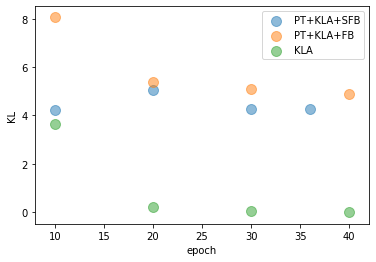

In [59]:
x1 = [10,20,30,36]
x2 = [10,20,30,40]
KL_SFB = [4.244, 5.07, 4.265, 4.265]
KL_FB = [8.09, 5.381, 5.076, 4.883]
KL_KA = [3.631,0.205, 0.028, 0.018]
plt.scatter(x1,KL_SFB, s=100, alpha=0.5, label = "PT+KLA+SFB")
plt.scatter(x2,KL_FB, s=100, alpha=0.5, label = "PT+KLA+FB")
plt.scatter(x2, KL_KA, s=100,alpha=0.5, label="KLA")
plt.xlabel('epoch')
plt.ylabel('KL')
plt.legend(loc = "upper right")
plt.show()

In [0]:
def label_point(x, y, val, ax):
  """
  From https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe/15911372#15911372
  """
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x'], point['y'], str(point['val']))

In [0]:
df_ka = pca_df()

In [0]:
df_ka['method'] = 'KLA'

In [0]:
df_fb = pca_df()

In [0]:
df_fb['method'] = 'free bits'

In [0]:
df_sfb = pca_df()

In [0]:
df_sfb['method'] = 'PT+KLA+SFB'

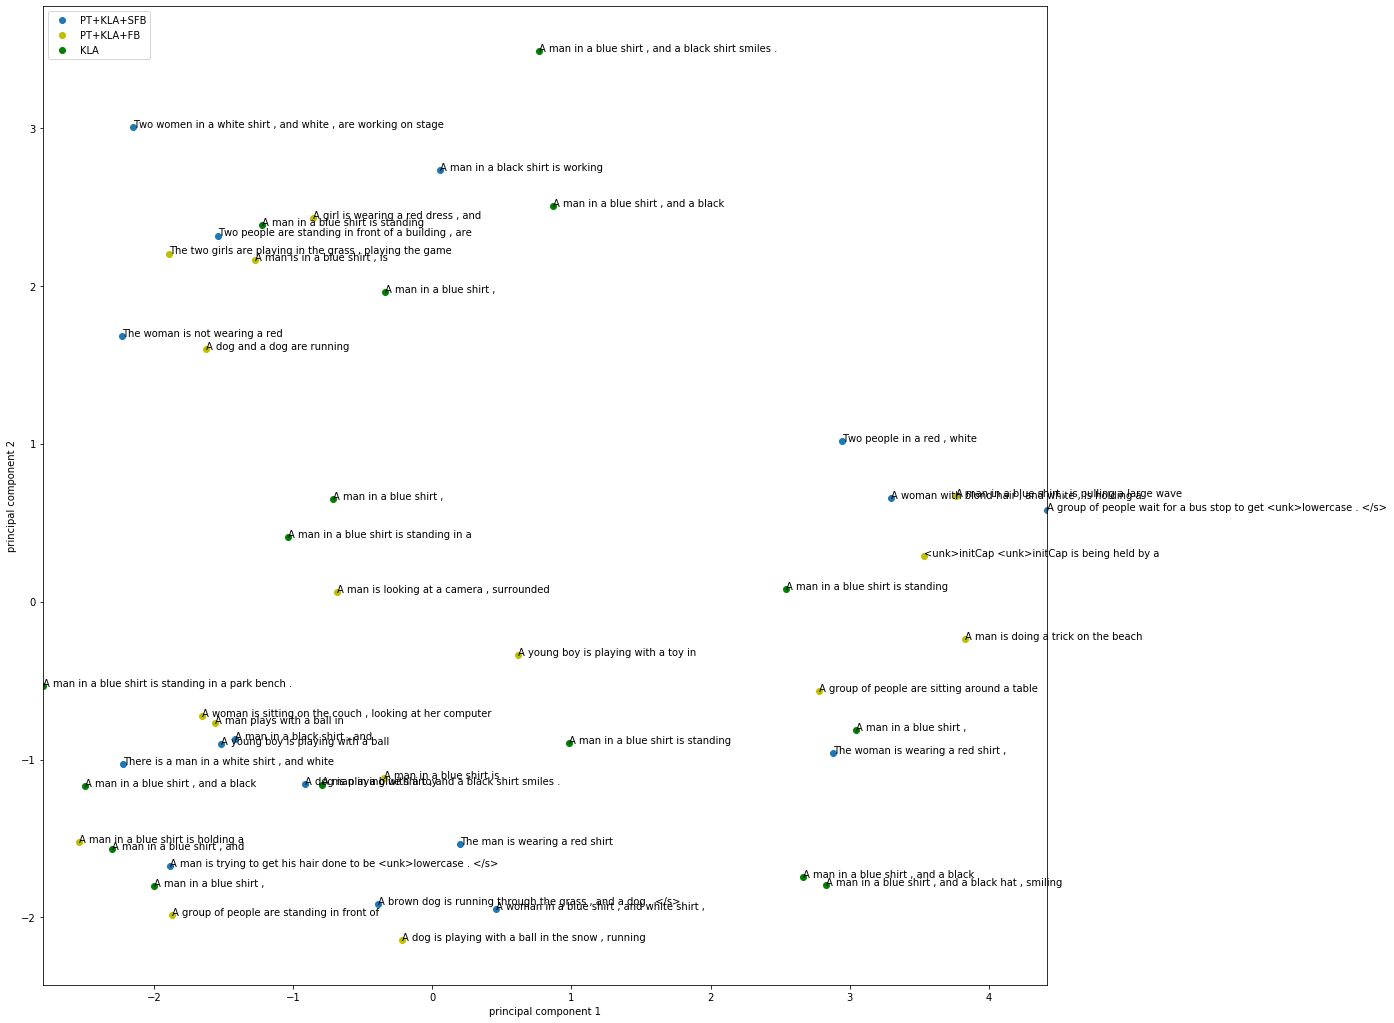

In [201]:
ax1 = df_sfb.set_index('principal component 1')['principal component 2'].plot(style='o')
ax3 = df_fb.set_index('principal component 1')['principal component 2'].plot(style='yo')
ax2 = df_ka.set_index('principal component 1')['principal component 2'].plot(style='go')

fig = plt.gcf()
fig.set_size_inches(18, 18)

label_point(df_ka['principal component 1'], df_ka['principal component 2'], df_ka.batch_decoded, ax2)
label_point(df_fb['principal component 1'], df_fb['principal component 2'], df_fb.batch_decoded, ax3)
label_point(df_sfb['principal component 1'], df_sfb['principal component 2'], df_sfb.batch_decoded, ax1)
plt.ylabel('principal component 2')
plt.legend(("PT+KLA+SFB","PT+KLA+FB","KLA"), loc = "upper left")
plt.draw()